# 🎖️ Path To Hero in Halo Infinite

This notebook provides the queries to assess the progress to the Hero rank in Halo Infinite. It requires two files to be present in the same folder with the notebook - `eventlog.db`, that is generated through film data analysis with the help of [`OpenSpartan/film-event-extractor`](https://github.com/OpenSpartan/film-event-extractor), and `workshop.db` which is a database file [generated by OpenSpartan Workshop](https://openspartan.com/docs/workshop/guides/how-to-query-local-data/). You can copy the data file from OpenSpartan Workshop for your XUID and rename it to `workshop.db`.

You only need `eventlog.db` if you want to query for first kill, death, and medal (other data is available but not captured in this notebook).

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

In [2]:
conn = sqlite3.connect('workshop.db')
event_conn = sqlite3.connect('eventlog.db')

## Weekly matches

In [3]:
df = pd.read_sql_query('''SELECT 
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    COUNT(*) AS MatchCount
FROM MatchStats
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND EXISTS (
        SELECT 1
        FROM json_each(Players) AS player
        WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    )
GROUP BY WeekStartDate
ORDER BY WeekStartDate;''', conn)

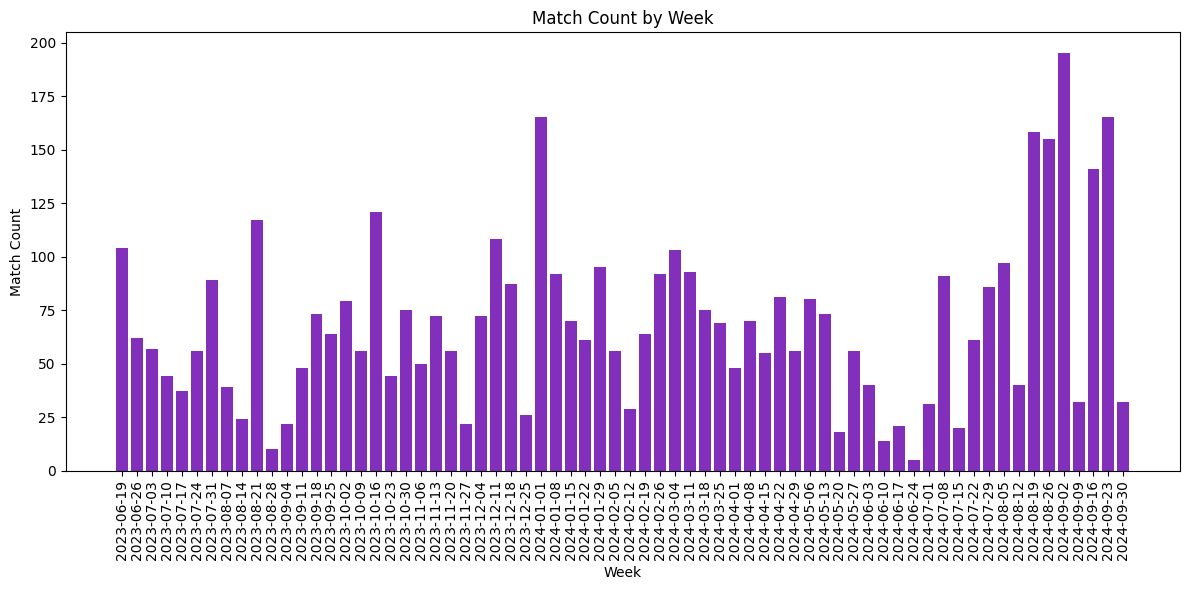

In [4]:
plt.figure(figsize=(12, 6))
plt.bar(df['WeekStartDate'], df['MatchCount'], color='#822fbb')
plt.xlabel('Week')
plt.ylabel('Match Count')
plt.title('Match Count by Week')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Monthly matches

In [5]:
df = pd.read_sql_query('''SELECT 
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    COUNT(*) AS MatchCount
FROM MatchStats
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND EXISTS (
        SELECT 1
        FROM json_each(Players) AS player
        WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    )
GROUP BY YearMonth
ORDER BY YearMonth;
''', conn)

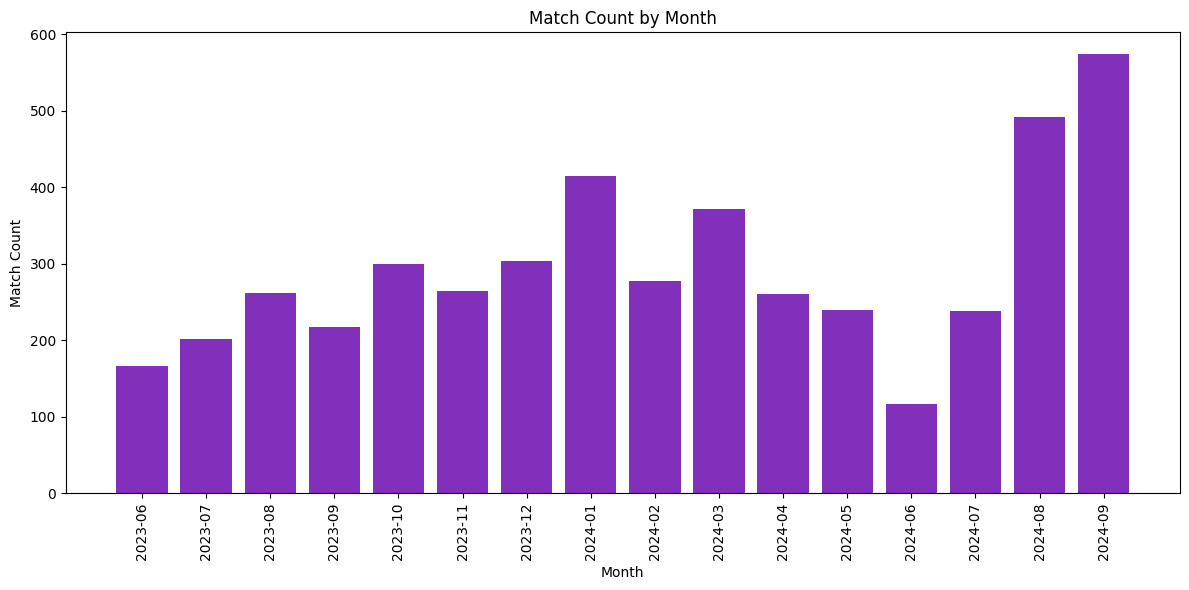

In [6]:
plt.figure(figsize=(12, 6))
plt.bar(df['YearMonth'], df['MatchCount'], color='#822fbb')
plt.xlabel('Month')
plt.ylabel('Match Count')
plt.title('Match Count by Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Players I played with

In [7]:
df = pd.read_sql_query('''WITH PlayerTeam AS (
    SELECT 
        MatchId, 
        json_extract(player.value, '$.LastTeamId') AS TeamId
    FROM MatchStats, json_each(Players) AS player
    WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
)
SELECT 
    json_extract(otherPlayer.value, '$.PlayerId') AS PlayerId,
    COUNT(DISTINCT MatchStats.MatchId) AS UniqueMatchCount
FROM MatchStats, json_each(Players) AS otherPlayer
WHERE 
    MatchStats.MatchId IN (SELECT MatchId FROM PlayerTeam) 
    AND json_extract(otherPlayer.value, '$.LastTeamId') = (SELECT TeamId FROM PlayerTeam WHERE PlayerTeam.MatchId = MatchStats.MatchId)
GROUP BY PlayerId
ORDER BY UniqueMatchCount DESC
''', conn)

df.head(10)

,PlayerId,UniqueMatchCount
0,xuid(2533274855333605),4699
1,xuid(2676022814299645),195
2,xuid(2535450430228717),175
3,xuid(2535461171399845),35
4,xuid(2689426384619306),34
5,xuid(2533274961303003),22
6,bid(45.0),19
7,xuid(2533274796148096),18
8,bid(51.0),16
9,bid(49.0),16


## Players I played against

In [8]:
df = pd.read_sql_query('''WITH PlayerTeam AS (
    SELECT 
        MatchId, 
        json_extract(player.value, '$.LastTeamId') AS TeamId
    FROM MatchStats, json_each(Players) AS player
    WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
)
SELECT 
    json_extract(otherPlayer.value, '$.PlayerId') AS PlayerId,
    COUNT(DISTINCT MatchStats.MatchId) AS UniqueMatchCount
FROM MatchStats, json_each(Players) AS otherPlayer
WHERE 
    MatchStats.MatchId IN (SELECT MatchId FROM PlayerTeam) 
    AND json_extract(otherPlayer.value, '$.LastTeamId') != (SELECT TeamId FROM PlayerTeam WHERE PlayerTeam.MatchId = MatchStats.MatchId)
GROUP BY PlayerId
ORDER BY UniqueMatchCount DESC
''', conn)

df.head(10)

,PlayerId,UniqueMatchCount
0,bid(0.0),26
1,bid(55.0),22
2,bid(27.0),22
3,bid(23.0),22
4,xuid(2535445394664181),21
5,xuid(2535450430228717),20
6,bid(5.0),20
7,bid(4.0),19
8,bid(13.0),19
9,bid(52.0),18


## Games in progress I've joined

In [9]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = true
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,Matches,WeekStartDate,Outcome
0,3,2023-06-19,3
1,2,2023-06-26,2
2,2,2023-06-26,3
3,2,2023-07-03,2
4,2,2023-07-03,3
5,1,2023-07-03,4
6,1,2023-07-10,2
7,4,2023-07-10,3
8,1,2023-07-17,2
9,4,2023-07-31,2


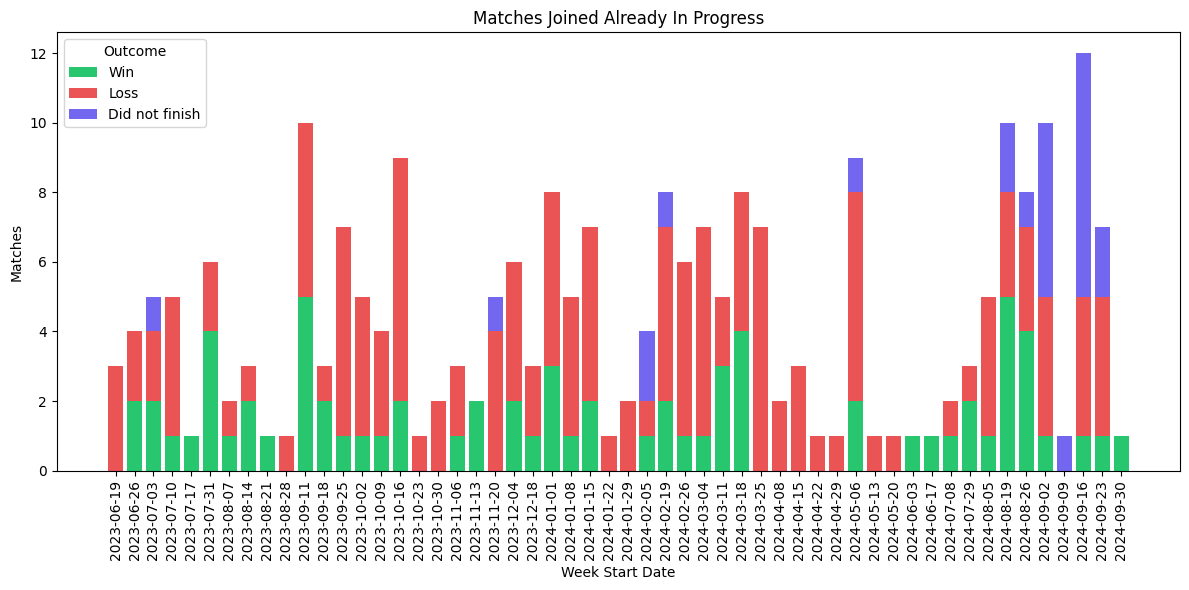

In [10]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}



stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)

        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Joined Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')
plt.show()

In [11]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = true
GROUP BY YearMonth, Outcome
ORDER BY YearMonth ASC;
''', conn)

df.head(10)

,Matches,YearMonth,Outcome
0,2,2023-06,2
1,5,2023-06,3
2,5,2023-07,2
3,6,2023-07,3
4,1,2023-07,4
5,7,2023-08,2
6,4,2023-08,3
7,8,2023-09,2
8,13,2023-09,3
9,4,2023-10,2


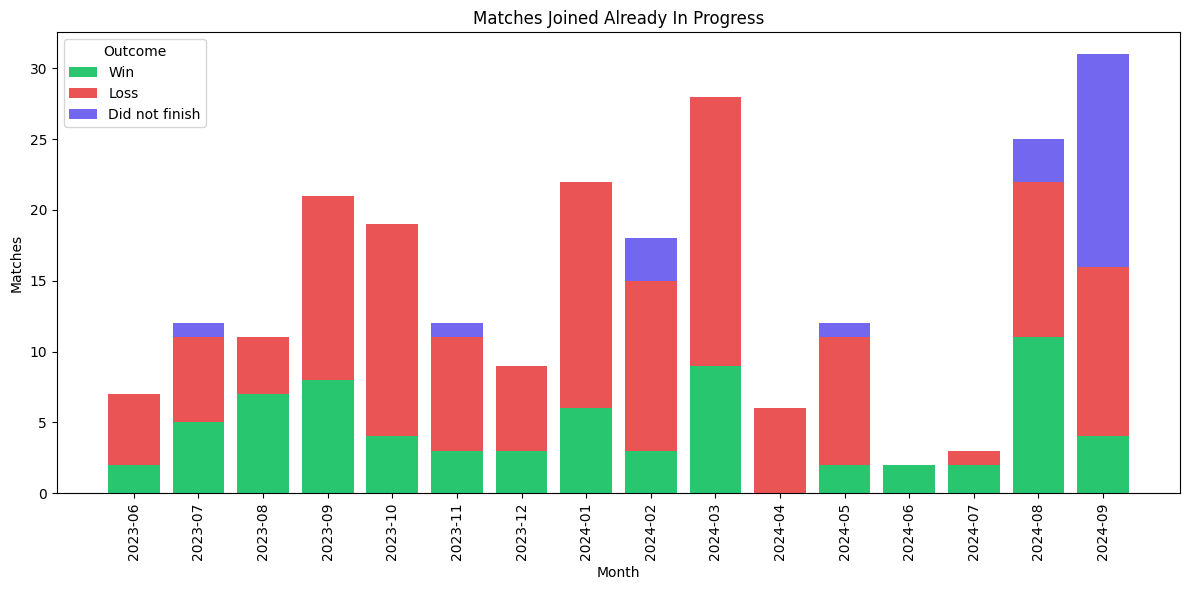

In [12]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='YearMonth', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        # Update the bottom values for stacking
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Month')
plt.ylabel('Matches')
plt.title('Matches Joined Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

## Games in progress I left

In [13]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,Matches,WeekStartDate,Outcome
0,1,2023-07-03,4
1,1,2023-07-24,4
2,1,2023-07-31,4
3,1,2023-08-21,4
4,1,2023-09-18,4
5,2,2023-09-25,4
6,1,2023-10-02,4
7,3,2023-10-16,4
8,4,2023-10-30,4
9,3,2023-11-06,4


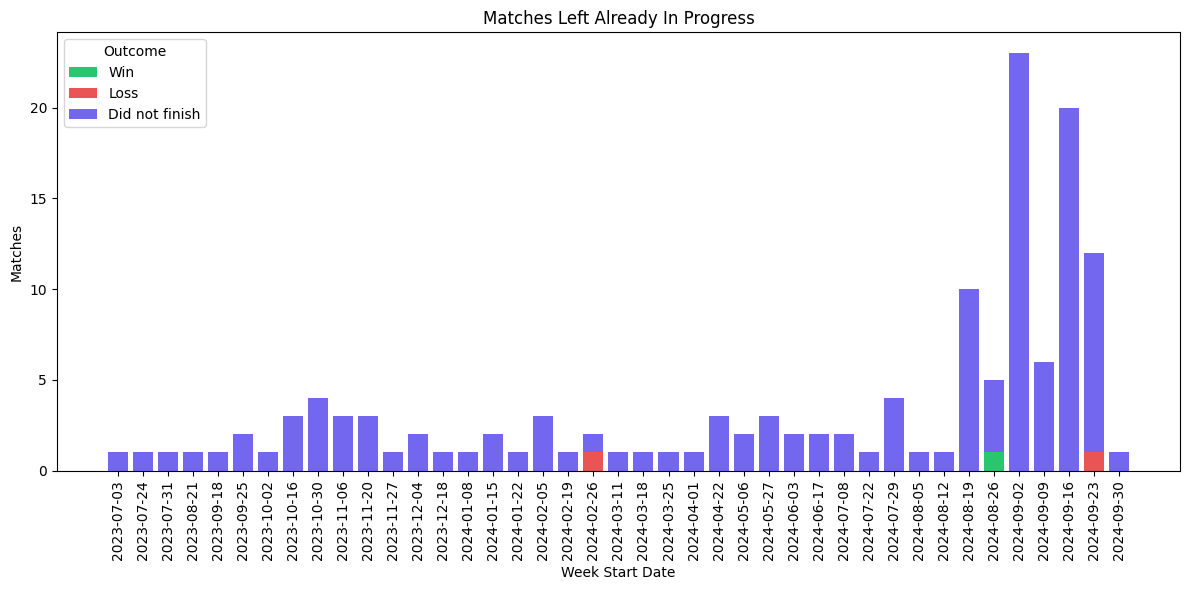

In [14]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Left Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

In [15]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY YearMonth, Outcome
ORDER BY YearMonth ASC;
''', conn)

df.head(10)

,Matches,YearMonth,Outcome
0,2,2023-07,4
1,2,2023-08,4
2,3,2023-09,4
3,4,2023-10,4
4,11,2023-11,4
5,3,2023-12,4
6,4,2024-01,4
7,1,2024-02,3
8,5,2024-02,4
9,3,2024-03,4


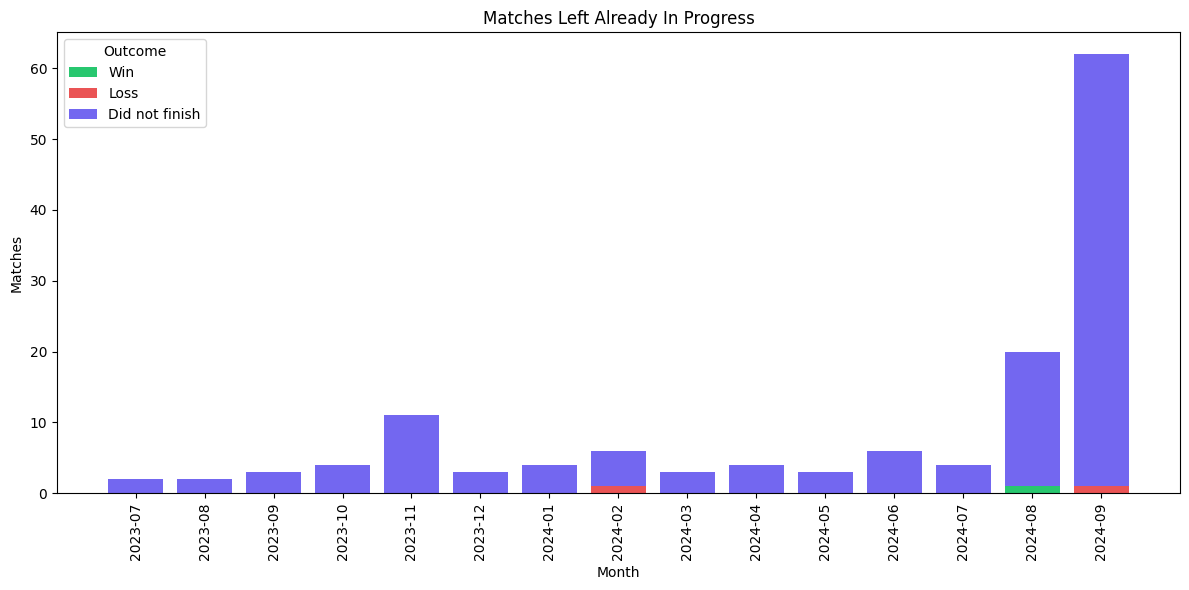

In [16]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='YearMonth', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))
bottom_values = [0] * len(stacked_data)
for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)

        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
plt.xlabel('Month')
plt.ylabel('Matches')
plt.title('Matches Left Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

## Maps I quit the match on

In [17]:
df = pd.read_sql_query('''SELECT
    COUNT(DISTINCT MatchId) AS Matches,
    json_extract(MatchInfo, '$.MapVariant.AssetId') AS AssetId,
    Maps.PublicName
FROM MatchStats, json_each(Players) AS player
JOIN Maps ON json_extract(MatchInfo, '$.MapVariant.AssetId') = Maps.AssetId
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY AssetId, Maps.PublicName  -- Group by AssetId and PublicName
ORDER BY Matches DESC;
''', conn)

df.head(10)

,Matches,AssetId,PublicName
0,49,525451ca-0bfa-4b5c-8a0f-29524e0f2834,Disciple
1,12,2c9df7e9-89e7-430a-8615-32474d4617c1,Formation
2,5,8be179f7-8940-4868-b881-44cad1ca8711,Corpo
3,5,aab54656-a45c-4724-8205-6778ae62db64,Ronin
4,4,1612a412-a7bc-49eb-829f-cea9d537052d,Scarlett's Landing
5,4,37a9b5f0-6be7-4a46-8010-1fe6f7ea5611,Ruujaya
6,4,50a1a3b5-c54d-4e40-8744-b92051d48897,Diminished
7,4,88d45250-97dd-4a28-8fb2-b52baaeebb39,Pharaoh
8,3,2bfd7643-1091-40b1-a889-2c5fc6367c25,Smallhalla
9,3,c395f3ac-4614-45f9-a83a-56f69e8ae962,Aquarius


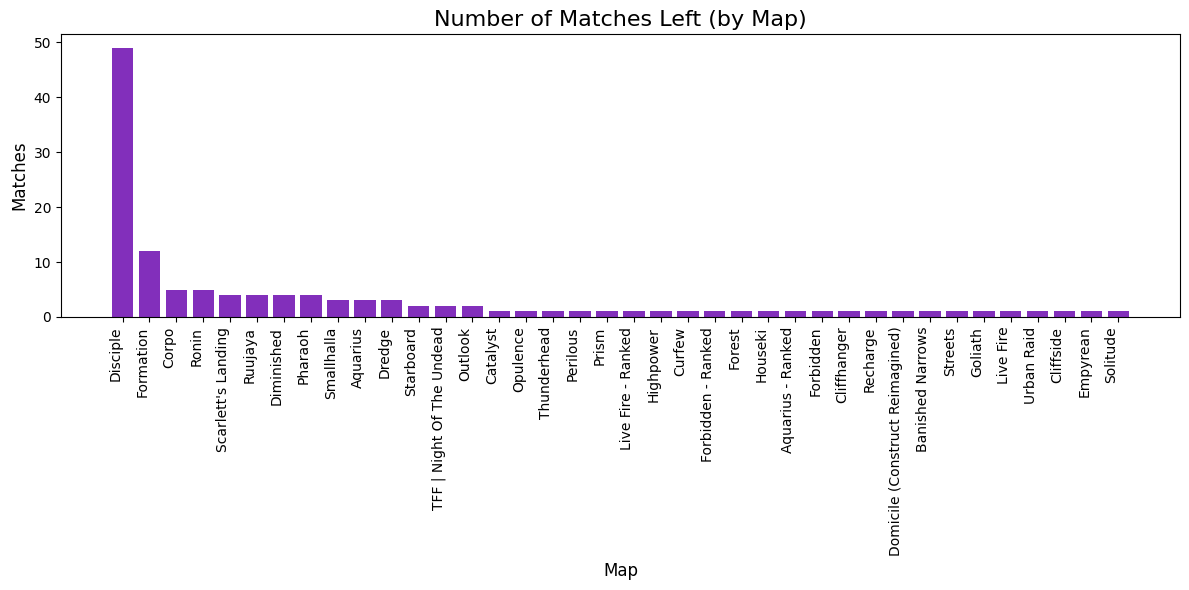

In [18]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df['PublicName'], df['Matches'], color='#822fbb')

plt.title('Number of Matches Left (by Map)', fontsize=16)
plt.xlabel('Map', fontsize=12)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

## Breakdown of matches played by game variant

In [19]:
df = pd.read_sql_query('''SELECT 
    json_extract(MatchStats.MatchInfo, '$.UgcGameVariant.AssetId') AS UgcGameVariantAssetId,
    GameVariants.PublicName,
    COUNT(DISTINCT MatchId) AS Matches
FROM MatchStats
JOIN GameVariants 
    ON json_extract(MatchStats.MatchInfo, '$.UgcGameVariant.AssetId') = GameVariants.AssetId
WHERE 
    datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
    AND json_extract(MatchStats.MatchInfo, '$.LifecycleMode') = 3
GROUP BY UgcGameVariantAssetId
ORDER BY Matches DESC;
''', conn)

df.head(10)

,UgcGameVariantAssetId,PublicName,Matches
0,0e198591-ac15-4f99-8ff2-dd390decad66,Super Husky Raid:CTF,1842
1,2fa07c0b-88e8-4453-8b3b-dc8c66c49ae0,Husky Raid:CTF,777
2,dc2e83f5-1afd-4612-9f27-63fd41df6db7,Tactical:Slayer,486
3,44f272c6-c783-4154-91da-849f08c17161,Ranked:Tactical Slayer,324
4,53af082c-bf21-4867-bea4-c038d10d133f,Tactical:Slayer Bandit,167
5,71689416-ec07-4f30-86a9-8229ebc20762,Arena:Team Slayer,113
6,729aea56-8b9e-4e72-ad82-ad9758d4f4b6,Arena:FFA Rock 'n' Repulsors Slayer,111
7,1e8cd10b-1496-423b-8699-f98f6f5db67e,Arena:Slayer,88
8,c2d20d44-8606-4669-b894-afae15b3524f,Ranked:Slayer,86
9,43eba883-7984-420a-90ee-4d64f4df55d6,Event:Infection,80


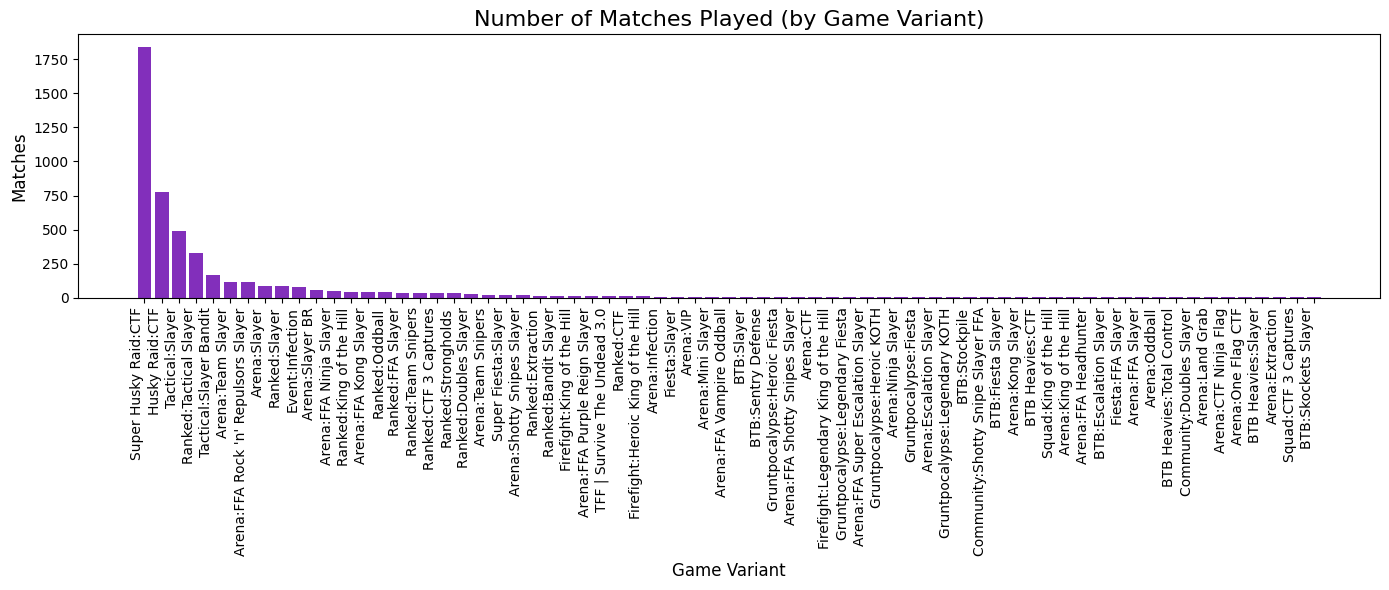

In [20]:
plt.figure(figsize=(14, 6))  # Set the figure size
plt.bar(df['PublicName'], df['Matches'], color='#822fbb')

plt.title('Number of Matches Played (by Game Variant)', fontsize=16)
plt.xlabel('Game Variant', fontsize=12)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

## Breakdown of matches played by map

In [21]:
df = pd.read_sql_query('''SELECT 
    json_extract(MatchStats.MatchInfo, '$.MapVariant.AssetId') AS MapVariantAssetId,
    Maps.PublicName,
    COUNT(DISTINCT MatchId) AS Matches
FROM MatchStats
JOIN Maps 
    ON json_extract(MatchStats.MatchInfo, '$.MapVariant.AssetId') = Maps.AssetId
WHERE 
    datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
    AND json_extract(MatchStats.MatchInfo, '$.LifecycleMode') = 3
GROUP BY MapVariantAssetId
ORDER BY Matches DESC;
''', conn)

df.head(10)

,MapVariantAssetId,PublicName,Matches
0,8be179f7-8940-4868-b881-44cad1ca8711,Corpo,246
1,50a1a3b5-c54d-4e40-8744-b92051d48897,Diminished,241
2,ea7b30e6-d1b9-4c2c-a9e0-de955c48525d,Outlook,180
3,2c9df7e9-89e7-430a-8615-32474d4617c1,Formation,166
4,be848f91-3d87-4b80-8eb9-df3b52cb8d10,Urban Raid,164
5,88d45250-97dd-4a28-8fb2-b52baaeebb39,Pharaoh,160
6,37a9b5f0-6be7-4a46-8010-1fe6f7ea5611,Ruujaya,160
7,e67f1328-48b5-4d63-a577-4e03a5ee0673,Megapolis,153
8,7dfec55d-d968-4a38-aa68-bc31e8874cfd,Merchant's Square,150
9,aab54656-a45c-4724-8205-6778ae62db64,Ronin,141


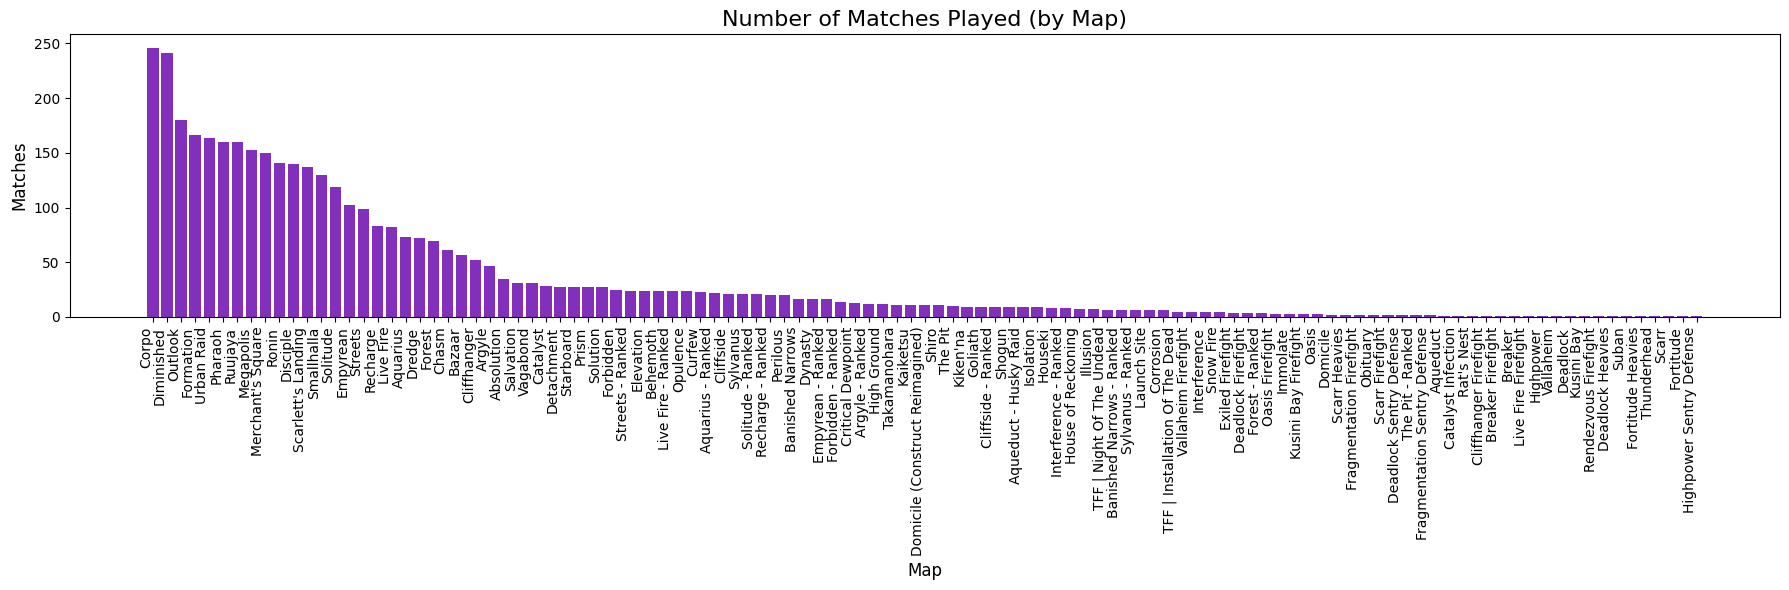

In [22]:
plt.figure(figsize=(18, 6))  # Set the figure size
plt.bar(df['PublicName'], df['Matches'], color='#822fbb')

plt.title('Number of Matches Played (by Map)', fontsize=16)
plt.xlabel('Map', fontsize=12)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

## Weekly outcomes

In [23]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,Matches,WeekStartDate,Outcome
0,1,2023-06-19,1
1,38,2023-06-19,2
2,65,2023-06-19,3
3,23,2023-06-26,2
4,39,2023-06-26,3
5,24,2023-07-03,2
6,32,2023-07-03,3
7,1,2023-07-03,4
8,21,2023-07-10,2
9,23,2023-07-10,3


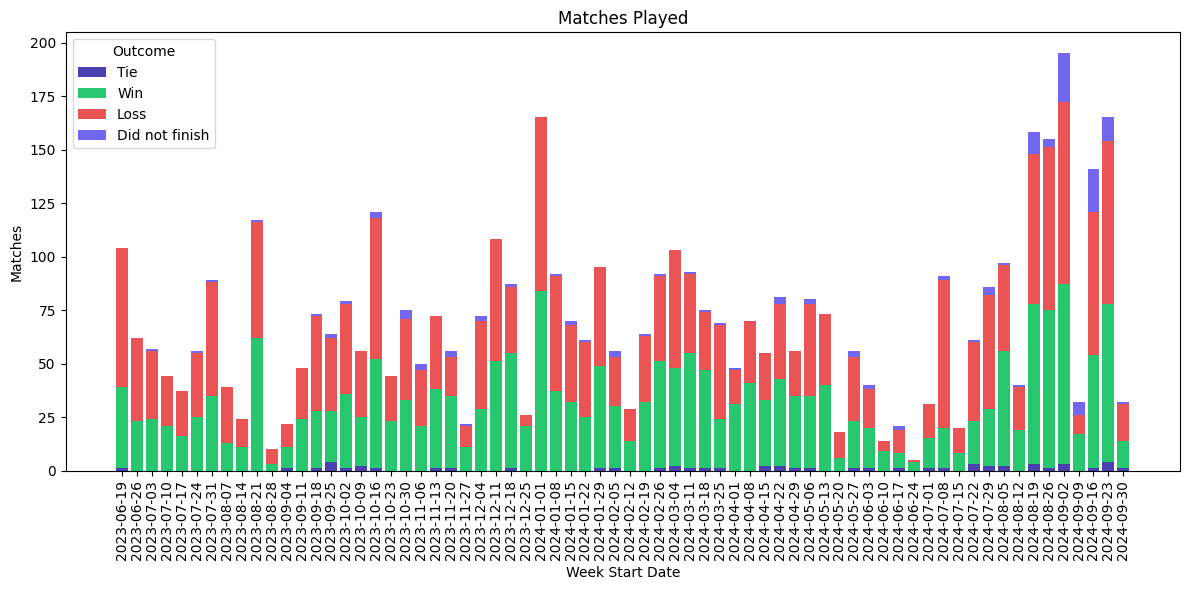

In [24]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)

        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Played')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

## Win rate

In [25]:
df = pd.read_sql_query('''SELECT
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    COUNT(DISTINCT MatchId) AS TotalMatches,
    SUM(CASE 
        WHEN json_extract(player.value, '$.Outcome') = 2 THEN 1 
        WHEN json_extract(player.value, '$.Outcome') = 1 THEN 1 
        ELSE 0 
    END) AS WinsOrTies,
    ROUND(
        CAST(SUM(CASE 
            WHEN json_extract(player.value, '$.Outcome') = 2 THEN 1 
            WHEN json_extract(player.value, '$.Outcome') = 1 THEN 1 
            ELSE 0 
        END) AS FLOAT) / COUNT(DISTINCT MatchId), 2
    ) AS WinRatio
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,WeekStartDate,TotalMatches,WinsOrTies,WinRatio
0,2023-06-19,104,39,0.38
1,2023-06-26,62,23,0.37
2,2023-07-03,57,24,0.42
3,2023-07-10,44,21,0.48
4,2023-07-17,37,16,0.43
5,2023-07-24,56,25,0.45
6,2023-07-31,89,35,0.39
7,2023-08-07,39,13,0.33
8,2023-08-14,24,11,0.46
9,2023-08-21,117,62,0.53


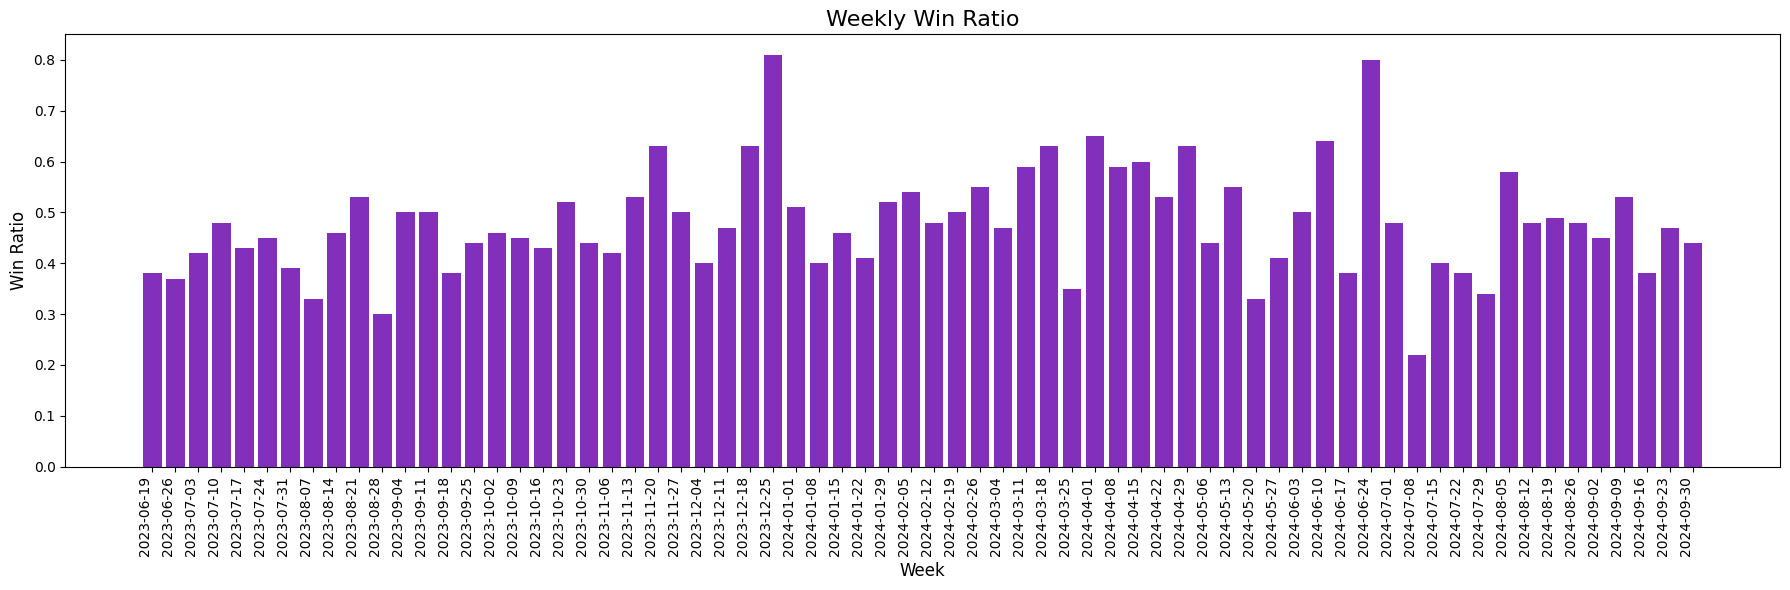

In [26]:
plt.figure(figsize=(18, 6))  # Set the figure size
plt.bar(df['WeekStartDate'], df['WinRatio'], color='#822fbb')

plt.title('Weekly Win Ratio', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Win Ratio', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()

plt.show()

## Median win ratio

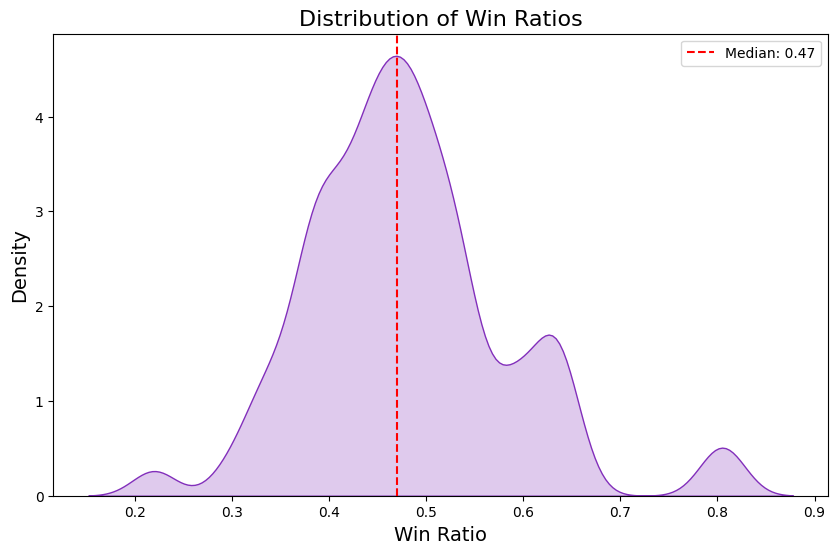

In [27]:
median_win_ratio = df['WinRatio'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['WinRatio'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_win_ratio, color='red', linestyle='--', label=f'Median: {median_win_ratio:.2f}')

plt.title('Distribution of Win Ratios', fontsize=16)
plt.xlabel('Win Ratio', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Winning streaks

In [28]:
df = pd.read_sql_query('''WITH RankedMatches AS (
    SELECT
        MatchId,
        date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
        json_extract(player.value, '$.Outcome') AS Outcome,
        ROW_NUMBER() OVER (PARTITION BY date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) 
                           ORDER BY datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS RowNum
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
        AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
),
Streaks AS (
    SELECT
        WeekStartDate,
        Outcome,
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate ORDER BY RowNum) - 
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate, (CASE WHEN Outcome IN (1, 2) THEN 0 ELSE 1 END) ORDER BY RowNum) AS StreakGroup
    FROM RankedMatches
)
SELECT
    WeekStartDate,
    MAX(StreakLength) AS LongestWinningStreak
FROM (
    SELECT
        WeekStartDate,
        COUNT(*) AS StreakLength
    FROM Streaks
    WHERE Outcome IN (1, 2)  -- Include both wins and ties
    GROUP BY WeekStartDate, StreakGroup
)
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,WeekStartDate,LongestWinningStreak
0,2023-06-19,4
1,2023-06-26,3
2,2023-07-03,7
3,2023-07-10,4
4,2023-07-17,3
5,2023-07-24,4
6,2023-07-31,7
7,2023-08-07,3
8,2023-08-14,3
9,2023-08-21,8


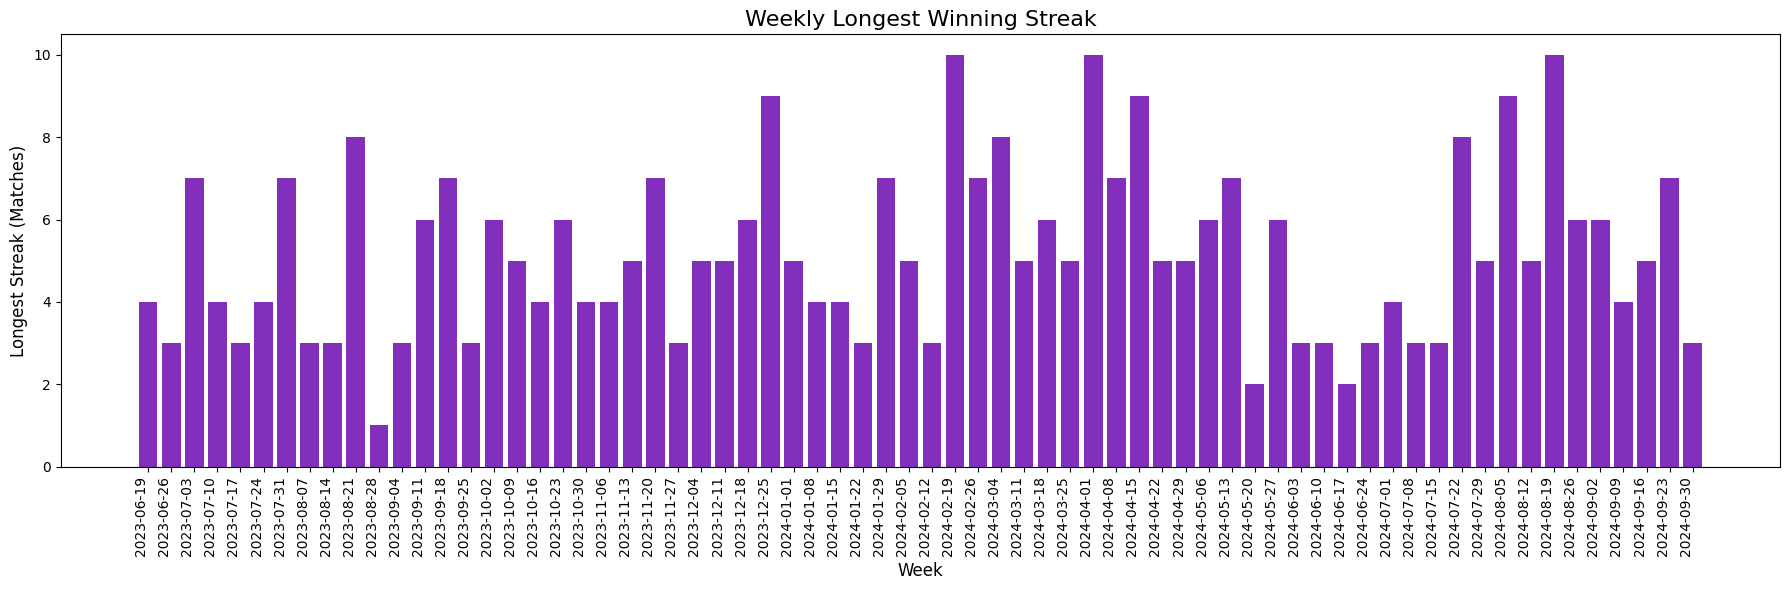

In [29]:
plt.figure(figsize=(18, 6))
plt.bar(df['WeekStartDate'], df['LongestWinningStreak'], color='#822fbb')

plt.title('Weekly Longest Winning Streak', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Longest Streak (Matches)', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

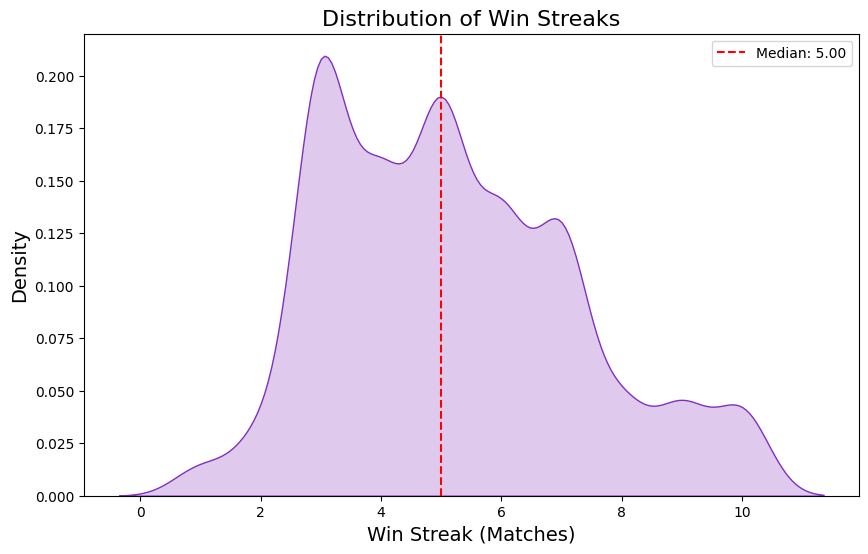

In [30]:
median_win_streak = df['LongestWinningStreak'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['LongestWinningStreak'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_win_streak, color='red', linestyle='--', label=f'Median: {median_win_streak:.2f}')

plt.title('Distribution of Win Streaks', fontsize=16)
plt.xlabel('Win Streak (Matches)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Losing streaks

In [31]:
df = pd.read_sql_query('''WITH RankedMatches AS (
    SELECT
        MatchId,
        date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
        json_extract(player.value, '$.Outcome') AS Outcome,
        ROW_NUMBER() OVER (PARTITION BY date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) 
                           ORDER BY datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS RowNum
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
        AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
),
Streaks AS (
    SELECT
        WeekStartDate,
        Outcome,
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate ORDER BY RowNum) - 
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate, (CASE WHEN Outcome IN (3) THEN 0 ELSE 1 END) ORDER BY RowNum) AS StreakGroup
    FROM RankedMatches
)
SELECT
    WeekStartDate,
    MAX(StreakLength) AS LongestLosingStreak
FROM (
    SELECT
        WeekStartDate,
        COUNT(*) AS StreakLength
    FROM Streaks
    WHERE Outcome IN (3)  -- Include both wins and ties
    GROUP BY WeekStartDate, StreakGroup
)
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,WeekStartDate,LongestLosingStreak
0,2023-06-19,8
1,2023-06-26,4
2,2023-07-03,8
3,2023-07-10,6
4,2023-07-17,9
5,2023-07-24,9
6,2023-07-31,14
7,2023-08-07,11
8,2023-08-14,4
9,2023-08-21,6


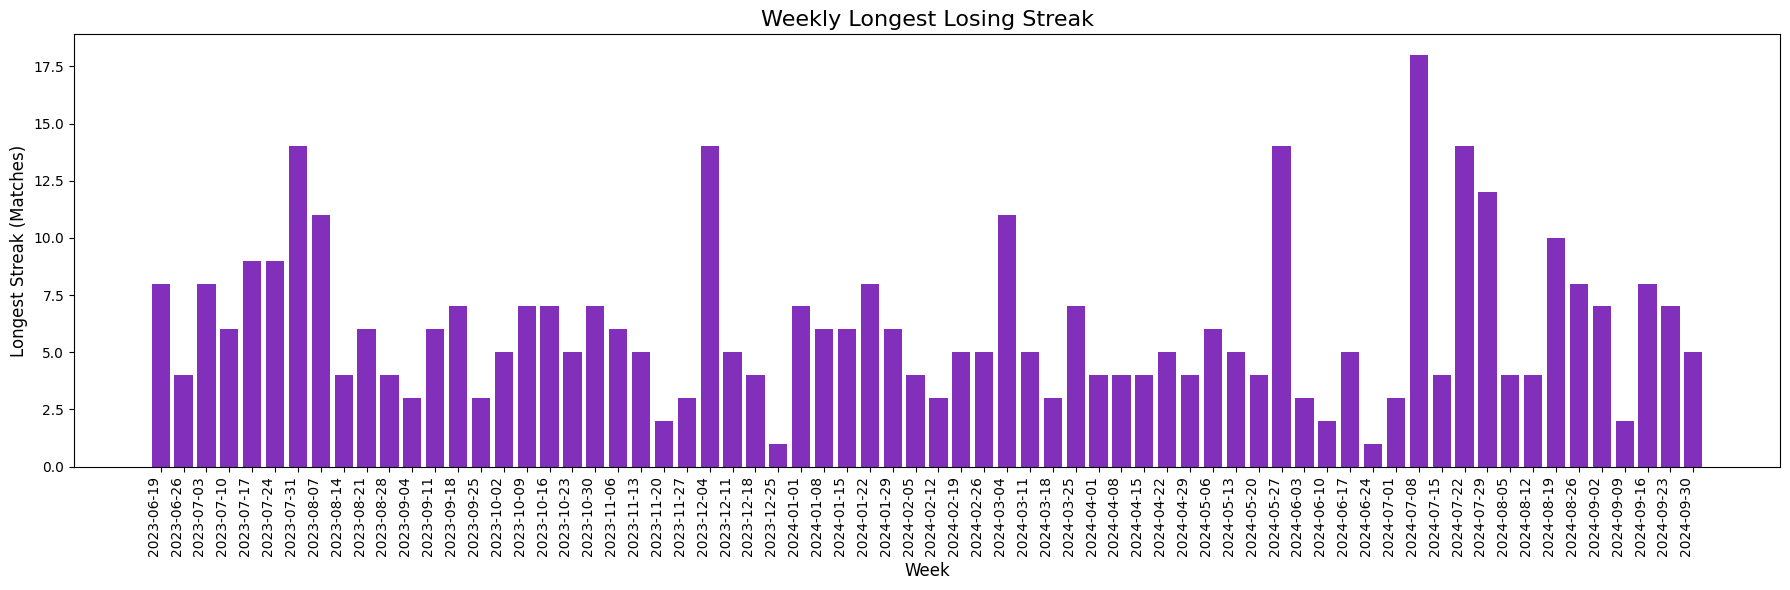

In [32]:
plt.figure(figsize=(18, 6))
plt.bar(df['WeekStartDate'], df['LongestLosingStreak'], color='#822fbb')

plt.title('Weekly Longest Losing Streak', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Longest Streak (Matches)', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()

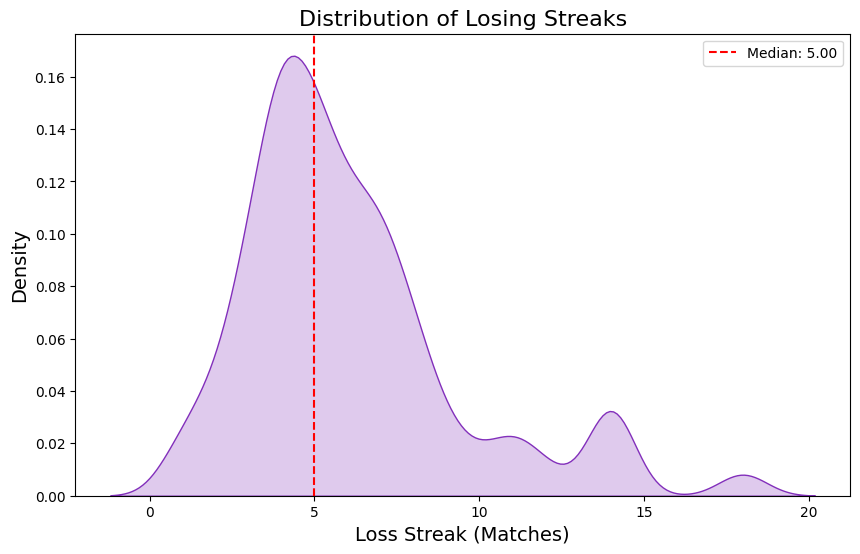

In [33]:
median_lose_streak = df['LongestLosingStreak'].median()
plt.figure(figsize=(10, 6))
sns.kdeplot(df['LongestLosingStreak'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_lose_streak, color='red', linestyle='--', label=f'Median: {median_lose_streak:.2f}')

plt.title('Distribution of Losing Streaks', fontsize=16)
plt.xlabel('Loss Streak (Matches)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Match personal score

In [34]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS PersonalScore
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,PersonalScore
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,900
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,1225
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,3665
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,1875
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,2105
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,3750
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,3980
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,2805
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,1500
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,5065


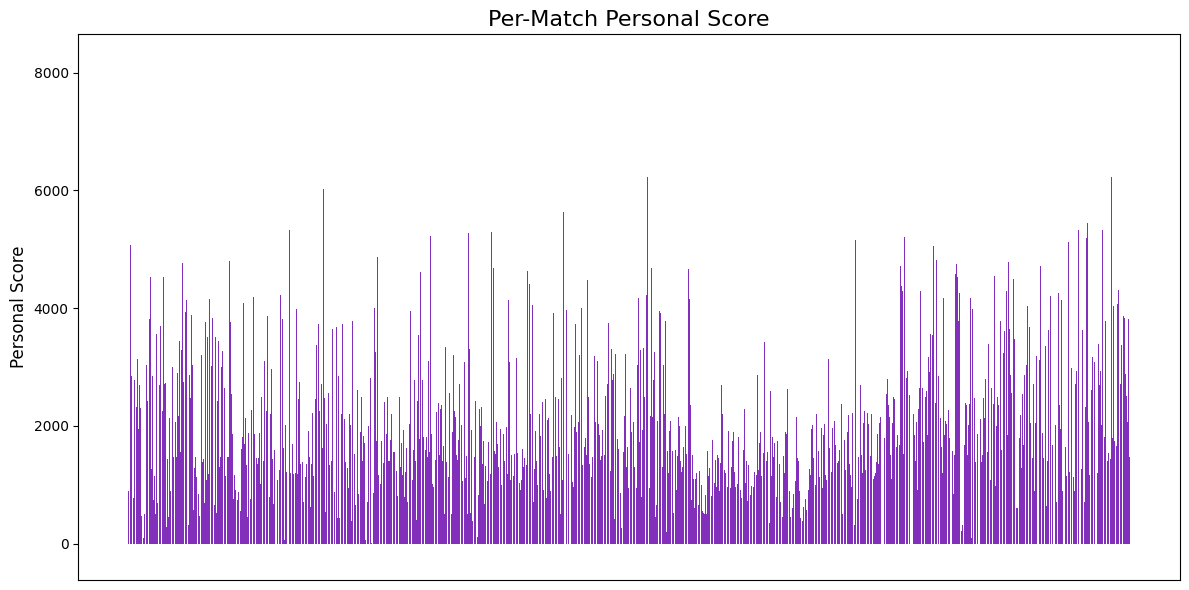

In [35]:
plt.figure(figsize=(12, 6))

plt.bar(df['MatchId'], df['PersonalScore'], color='#822fbb')

plt.title('Per-Match Personal Score', fontsize=16)
plt.ylabel('Personal Score', fontsize=12)

plt.gca().xaxis.set_visible(False)

plt.tight_layout()

plt.show()

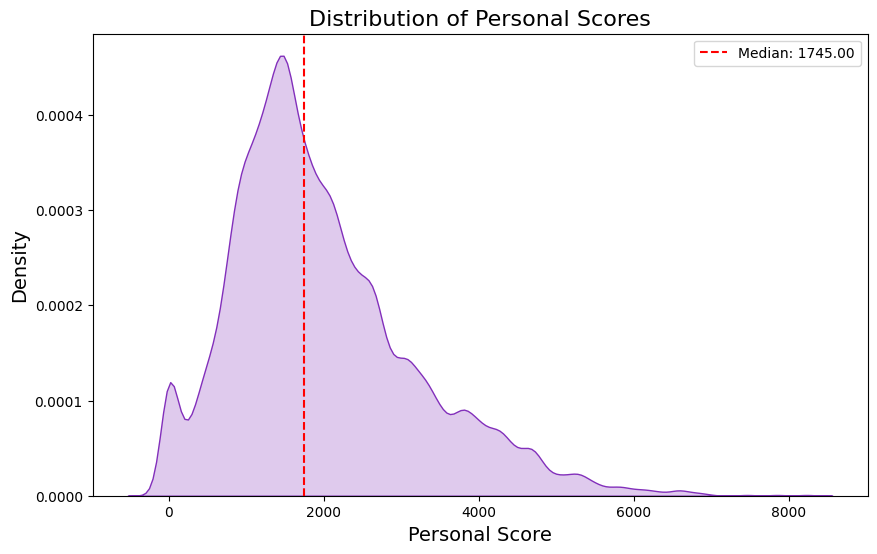

In [36]:
median_personal_score = df['PersonalScore'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['PersonalScore'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Personal Scores', fontsize=16)
plt.xlabel('Personal Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Weekly personal score

In [37]:
df = pd.read_sql_query('''SELECT
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    SUM(CAST(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS INTEGER)) AS TotalPersonalScore
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,WeekStartDate,TotalPersonalScore
0,2023-06-19,146295
1,2023-06-26,84510
2,2023-07-03,72885
3,2023-07-10,52315
4,2023-07-17,49290
5,2023-07-24,94530
6,2023-07-31,130470
7,2023-08-07,47160
8,2023-08-14,29760
9,2023-08-21,151415


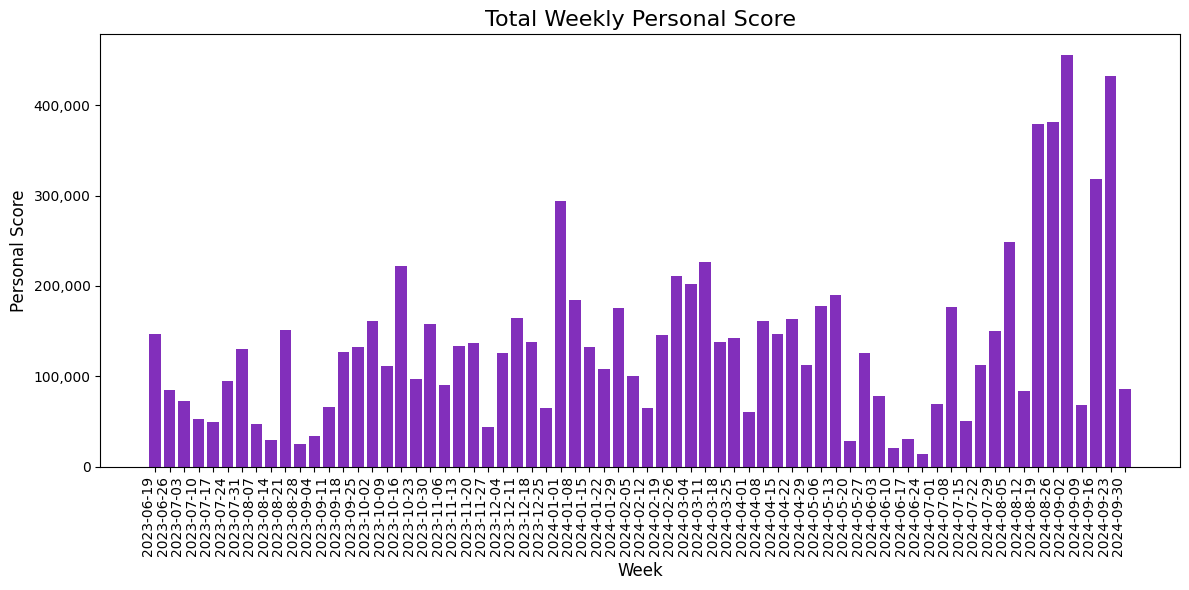

In [38]:
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))

plt.bar(df['WeekStartDate'], df['TotalPersonalScore'], color='#822fbb')

plt.title('Total Weekly Personal Score', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Personal Score', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

### Isolated to Super Husky Raid

In [39]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS PersonalScore
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') = '0e198591-ac15-4f99-8ff2-dd390decad66'
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,PersonalScore
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,900
1,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,2105
2,2bee1c75-17af-4624-a9b5-76bbe846b7bb,3750
3,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,3980
4,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,1500
5,49bffea6-aa6f-4880-9c33-1b415f0cf28a,5065
6,8e7c42b4-8233-4afd-b283-991e3d5c4074,1160
7,10b9d038-4ab8-4209-9ddb-e85038d1a85d,0
8,1b2f85cc-0518-4e68-bc0a-5a5398e55d27,1885
9,e5063c19-f61f-4487-b919-e841c0c43216,2225


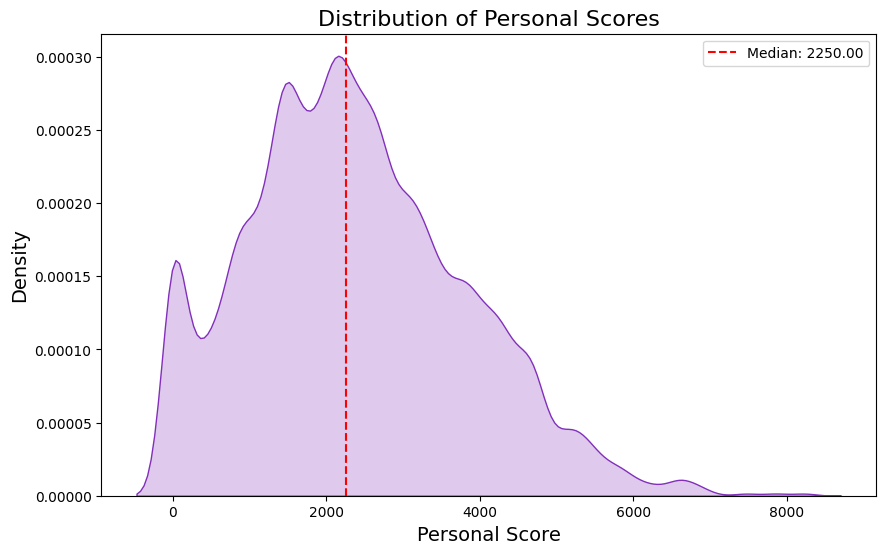

In [40]:
median_personal_score = df['PersonalScore'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['PersonalScore'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Personal Scores', fontsize=16)
plt.xlabel('Personal Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median kills

In [41]:
df = pd.read_sql_query('''SELECT
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,Kills
0,9
1,10
2,29
3,12
4,18
5,23
6,30
7,18
8,8
9,37


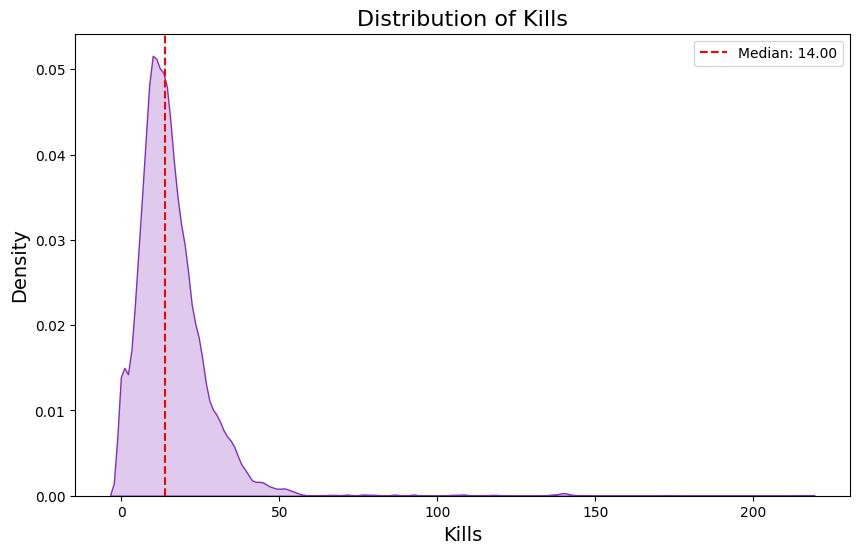

In [42]:
median_personal_score = df['Kills'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Kills'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Kills', fontsize=16)
plt.xlabel('Kills', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

### Excluding Firefight

In [43]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,Kills
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,9
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,10
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,29
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,12
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,18
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,23
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,30
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,18
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,8
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,37


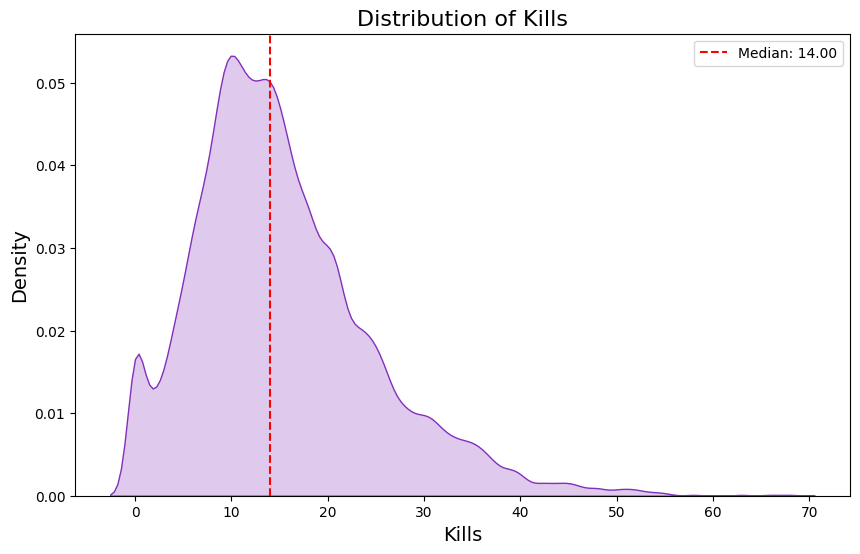

In [44]:
median_personal_score = df['Kills'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Kills'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Kills', fontsize=16)
plt.xlabel('Kills', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median deaths

In [45]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Deaths') AS Deaths
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,Deaths
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,16
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,12
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,23
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,16
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,16
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,19
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,26
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,11
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,20
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,20


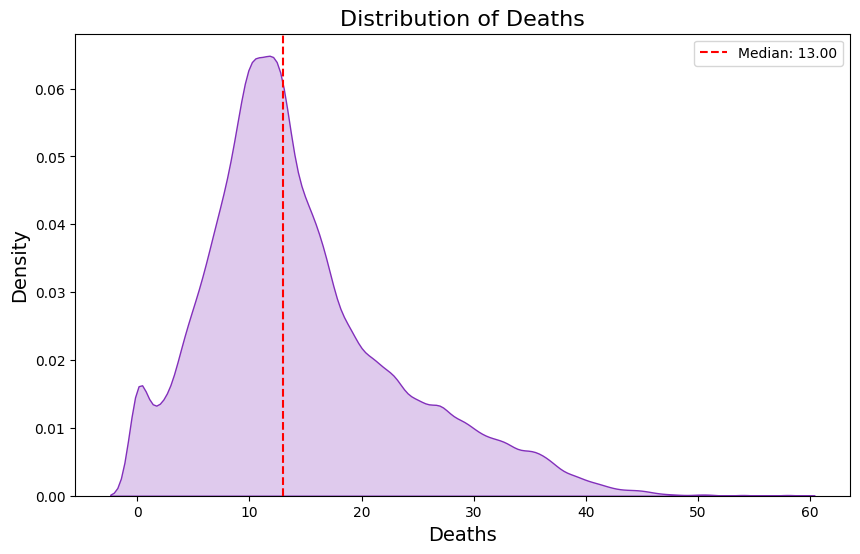

In [46]:
median_personal_score = df['Deaths'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Deaths'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Deaths', fontsize=16)
plt.xlabel('Deaths', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median assists

In [47]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Assists') AS Assists
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,Assists
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,2
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,3
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,13
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,9
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,4
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,9
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,12
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,3
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,5
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,10


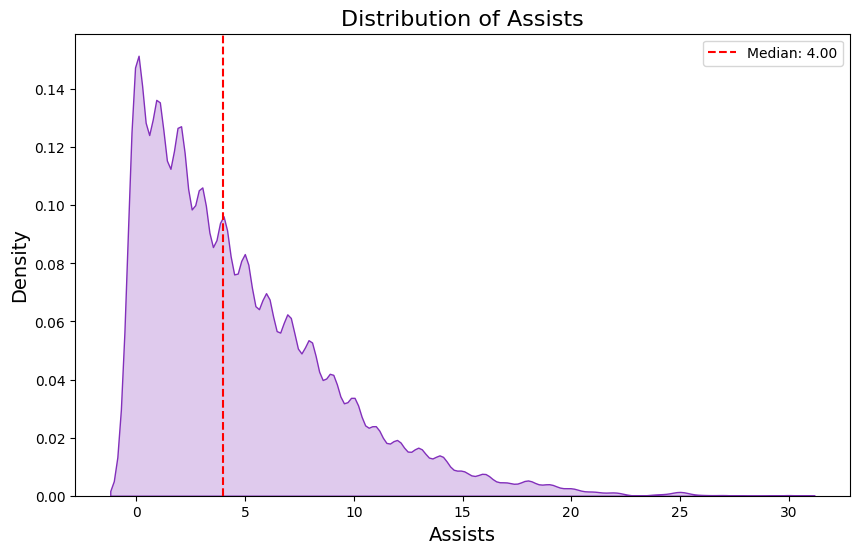

In [48]:
median_personal_score = df['Assists'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Assists'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Assists', fontsize=16)
plt.xlabel('Assists', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median life duration

In [49]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration') AS AverageLifeDuration
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,AverageLifeDuration
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,PT8.5S
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,PT9.7S
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,PT17.1S
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,PT17.1S
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,PT12.5S
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,PT22S
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,PT16.4S
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,PT22S
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,PT12.7S
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,PT18.4S


In [50]:
def duration_to_seconds(duration_str):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+\.?\d*)S)?', duration_str)
    
    hours = float(match.group(1)) if match.group(1) else 0
    minutes = float(match.group(2)) if match.group(2) else 0
    seconds = float(match.group(3)) if match.group(3) else 0
    
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

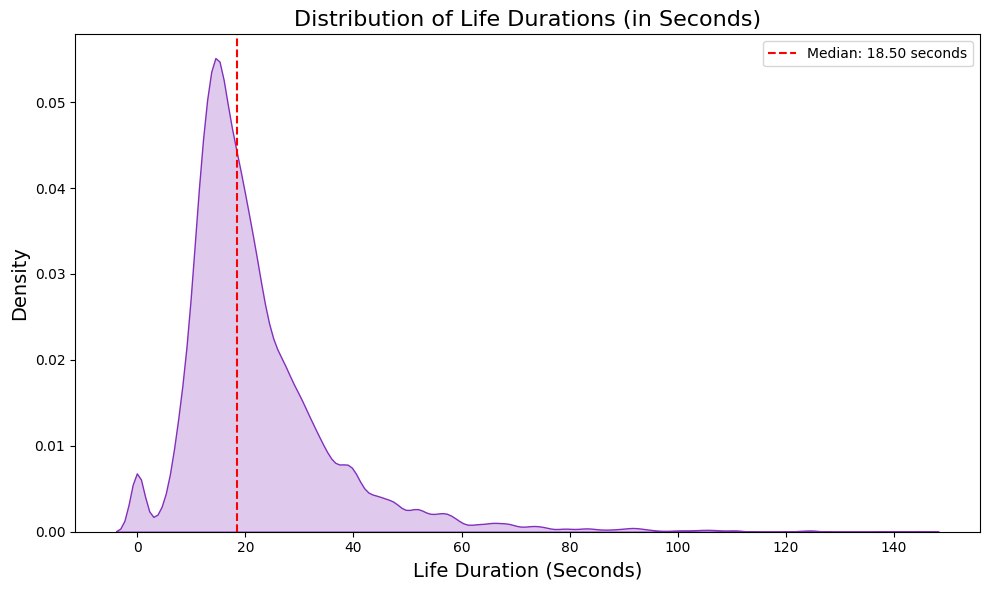

In [51]:
df['AverageLifeDurationSeconds'] = df['AverageLifeDuration'].apply(duration_to_seconds)

median_life_duration = df['AverageLifeDurationSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['AverageLifeDurationSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_life_duration, color='red', linestyle='--', label=f'Median: {median_life_duration:.2f} seconds')

plt.title('Distribution of Life Durations (in Seconds)', fontsize=16)
plt.xlabel('Life Duration (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Median accuracy

In [52]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Accuracy') AS Accuracy
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,Accuracy
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,30.32
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,40.20
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,53.47
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,50.64
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,34.61
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,37.05
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,40.00
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,54.05
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,30.47
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,34.78


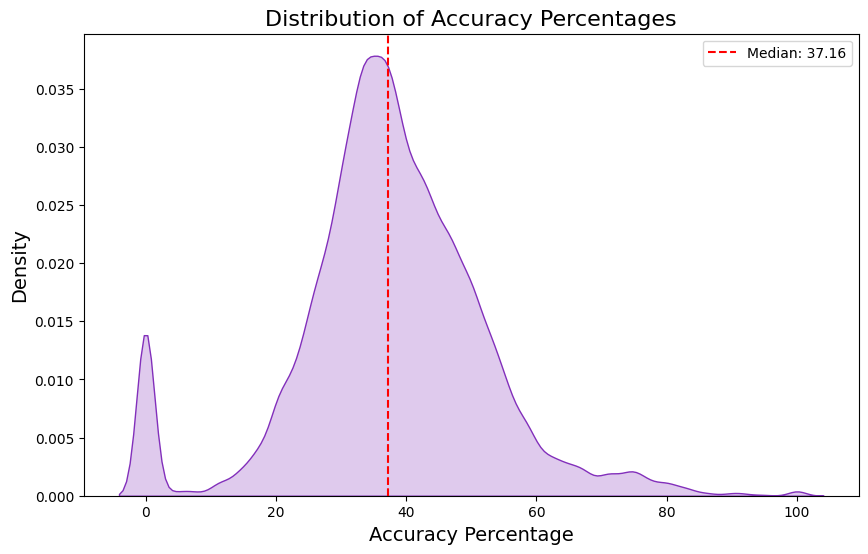

In [53]:
median_accuracy = df['Accuracy'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Accuracy'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_accuracy, color='red', linestyle='--', label=f'Median: {median_accuracy:.2f}')
plt.title('Distribution of Accuracy Percentages', fontsize=16)
plt.xlabel('Accuracy Percentage', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median KDA

In [54]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.KDA') AS KDA
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,KDA
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,-6.33
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,-1.00
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,10.33
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,-1.00
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,3.33
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,7.00
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,8.00
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,8.00
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,-10.33
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,20.33


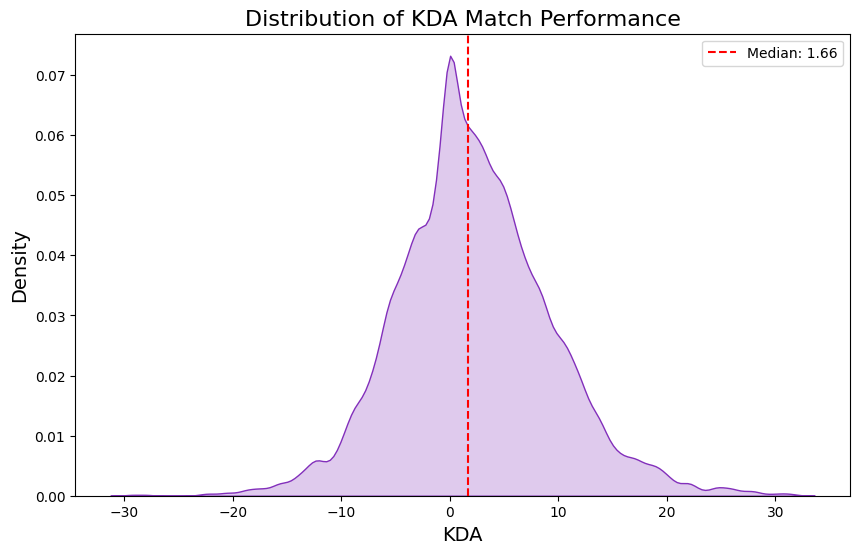

In [55]:
median_kda = df['KDA'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['KDA'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_kda, color='red', linestyle='--', label=f'Median: {median_kda:.2f}')

plt.title('Distribution of KDA Match Performance', fontsize=16)
plt.xlabel('KDA', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median match duration

In [56]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(MatchInfo, '$.Duration') AS Duration
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.Outcome') IN (1, 2, 3) 
''', conn)

df['DurationSeconds'] = df['Duration'].apply(duration_to_seconds)

df.head(10)

,MatchId,Duration,DurationSeconds
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,PT4M55.0169756S,295.016976
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,PT4M16.470175S,256.470175
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,PT10M30.679894S,630.679894
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,PT7M4.479578S,424.479578
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,PT5M53.2941253S,353.294125
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,PT10M21.4530865S,621.453087
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,PT11M0.9800707S,660.980071
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,PT6M44.1583369S,404.158337
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,PT8M4.504352S,484.504352
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,PT9M45.8091015S,585.809101


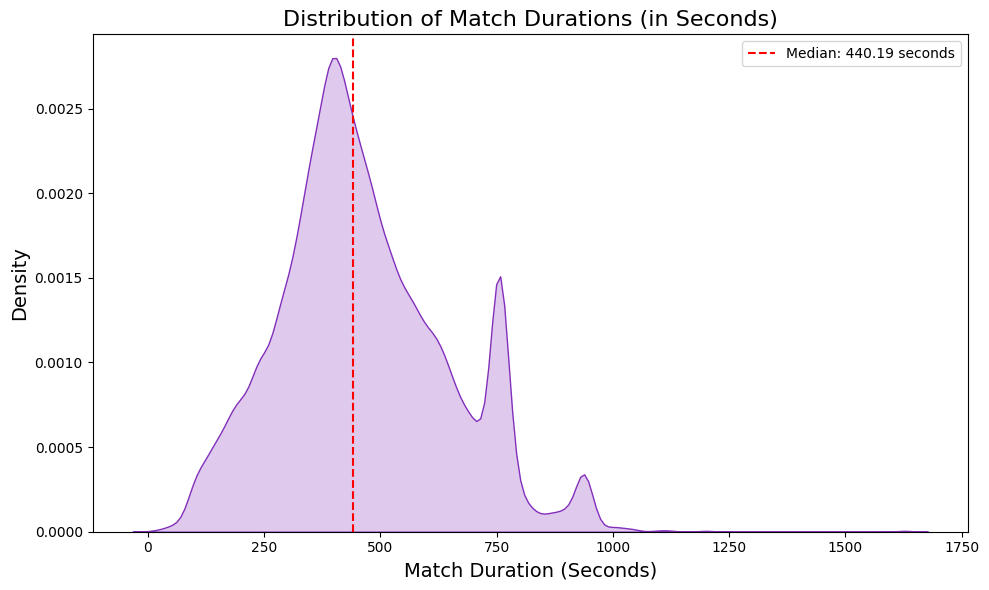

In [57]:
median_duration = df['DurationSeconds'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['DurationSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_duration, color='red', linestyle='--', label=f'Median: {median_duration:.2f} seconds')
plt.title('Distribution of Match Durations (in Seconds)', fontsize=16)
plt.xlabel('Match Duration (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Median damage dealt

In [58]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.DamageDealt') AS DamageDealt
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,DamageDealt
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,2166
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,2426
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,7530
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,4411
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,4572
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,5824
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,8699
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,4222
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,3244
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,9875


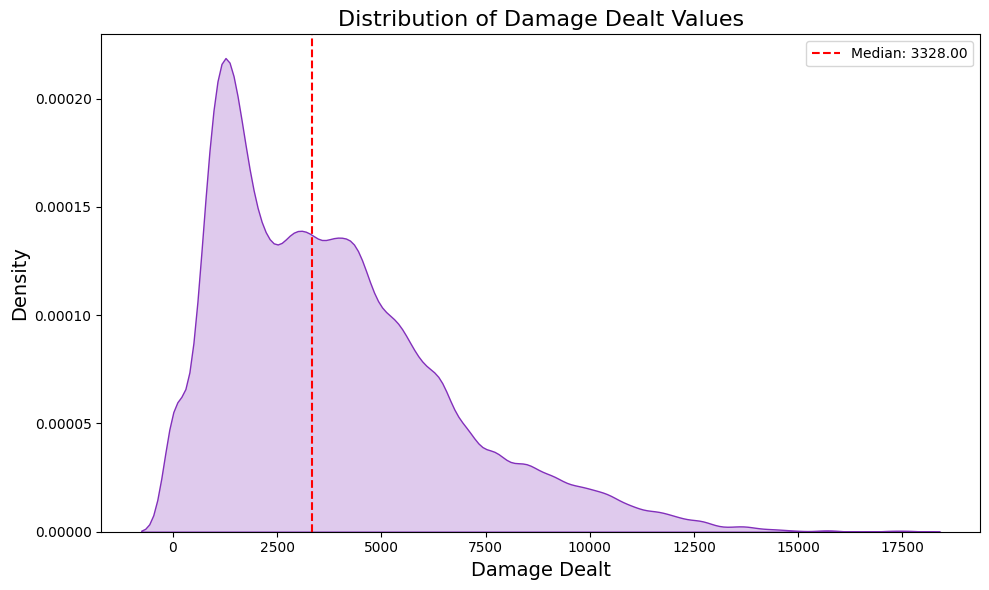

In [59]:

median_damage_dealt = df['DamageDealt'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['DamageDealt'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_damage_dealt, color='red', linestyle='--', label=f'Median: {median_damage_dealt:.2f}')
plt.title('Distribution of Damage Dealt Values', fontsize=16)
plt.xlabel('Damage Dealt', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Median damage taken

In [60]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.DamageTaken') AS DamageTaken
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

,MatchId,DamageTaken
0,9c83a3ae-feab-4498-8a5d-f7b09833982d,3659
1,ccaacac1-84bb-4c6c-9ba1-589655c26e83,2777
2,d9201be8-8e7f-4091-b85d-89ab8edc55bf,6000
3,dc1fa349-3344-4a97-bd1a-fbad0f5cc77c,4155
4,d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5,3816
5,2bee1c75-17af-4624-a9b5-76bbe846b7bb,5555
6,75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9,6916
7,f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b,3413
8,3f85e2c9-23de-4f3b-b2cb-4584d6da3598,4663
9,49bffea6-aa6f-4880-9c33-1b415f0cf28a,5875


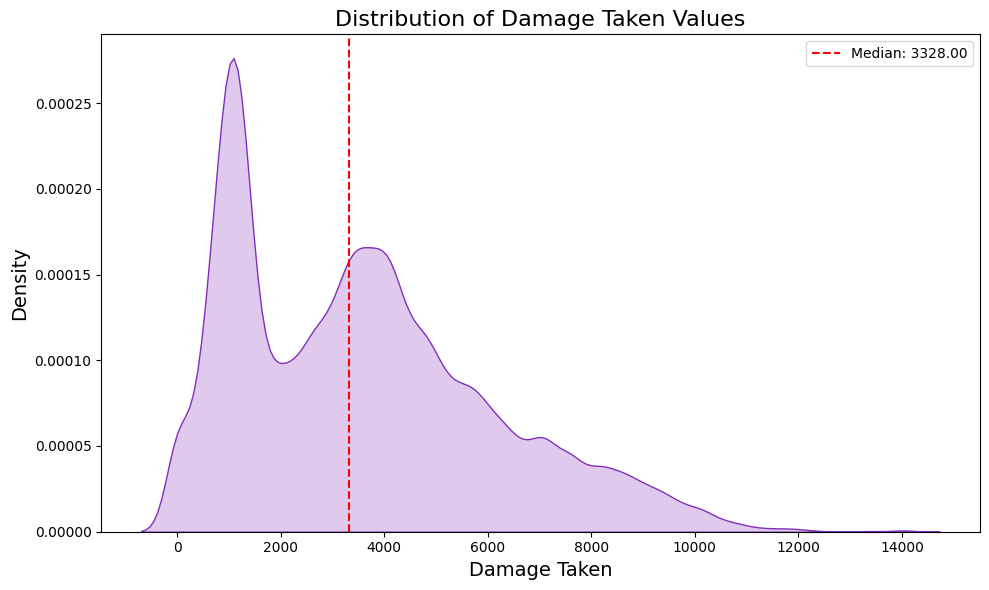

In [61]:
median_damage_taken = df['DamageTaken'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['DamageTaken'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_damage_dealt, color='red', linestyle='--', label=f'Median: {median_damage_dealt:.2f}')

plt.title('Distribution of Damage Taken Values', fontsize=16)
plt.xlabel('Damage Taken', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Median time to first kill

In [62]:
def milliseconds_to_seconds(ms_str):
    total_seconds = ms_str / 1000
    return total_seconds

In [63]:
df = pd.read_sql_query('''SELECT MatchID, MIN(EventTime) AS MinEventTime
FROM EventLog
WHERE XUID = '2533274855333605'
  AND EventType = 50
GROUP BY MatchID;
''', event_conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

,MatchID,MinEventTime,TimeToEventSeconds
0,001085B6-163A-41A4-AF83-C63BF7A4A59C,69746,69.746
1,0026E8C0-7D32-4E33-8A87-B2C031047E44,71229,71.229
2,00275CB5-A76D-4788-B0CA-43845D693EBA,156995,156.995
3,002F007A-D0F9-498F-BBBA-B2D740DDC40F,34568,34.568
4,00359920-24F5-431A-AA4F-A6A1FAD1E71F,43376,43.376
5,00386052-DC9E-43AD-A11F-66C602EF4821,60858,60.858
6,003FAB59-B1FA-4D42-8288-949950E600DD,32650,32.650
7,00704A1F-3214-4867-995D-7E317E5B96AB,39487,39.487
8,0074FE21-9F16-4317-8379-3F4CCC5DFB05,63373,63.373
9,00894B56-7DE3-4305-B4EE-80247F0F9D28,113469,113.469


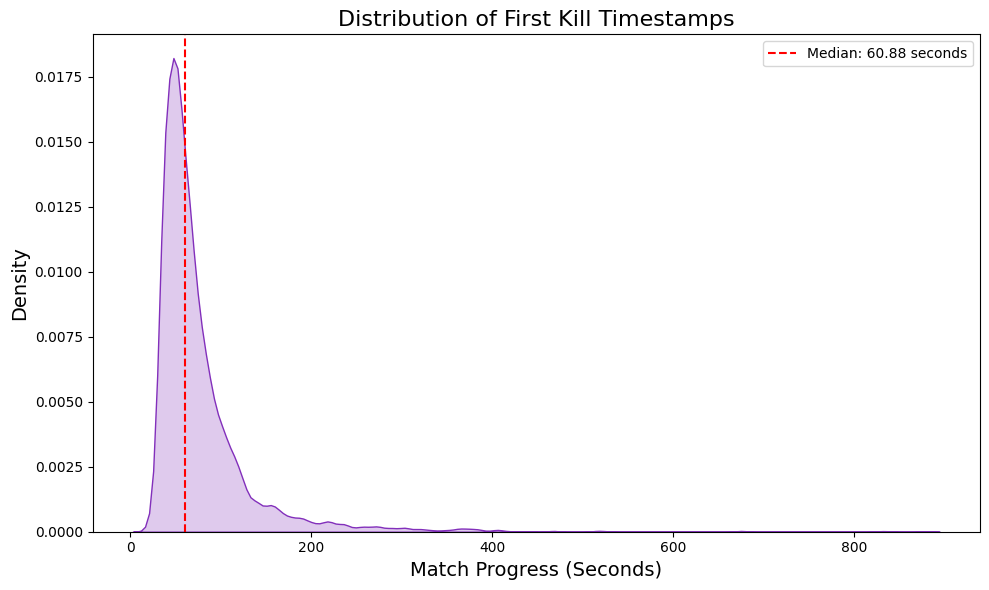

In [64]:
median_tte = df['TimeToEventSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')


plt.title('Distribution of First Kill Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()


plt.tight_layout()
plt.show()

## Limiting to matches I did not join in progress

In [65]:
conn.execute(f"ATTACH DATABASE 'eventlog.db' AS EventLog;")

In [66]:
df = pd.read_sql_query('''WITH EventLogData AS (
    SELECT LOWER(MatchID) MatchID, MIN(EventTime) AS MinEventTime
    FROM EventLog
    WHERE XUID = '2533274855333605'
      AND EventType = 50
    GROUP BY MatchID
)

SELECT
    ms.MatchId,
    el.MinEventTime
FROM MatchStats AS ms
JOIN EventLogData AS el ON ms.MatchId = el.MatchID
JOIN json_each(ms.Players) AS player ON json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
WHERE 
    datetime(json_extract(ms.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(ms.MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(ms.MatchInfo, '$.UgcGameVariant.AssetId') NOT IN (
        '1d641733-7cb2-4556-9ec3-f27923af32a1', 
        '15480417-fa8e-49a9-9d4b-e2ae90815562', 
        'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 
        'bc7f495b-c516-414e-acff-9718babe97a5', 
        '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 
        'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', 
        '3ec67f6c-4113-46d3-b94e-b70986625a15', 
        '219f8162-ef34-419e-939b-c3b9dafe3109', 
        'a598de90-4b3f-420a-83d4-c84ba89bf94c'
    )
    AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = false;
''', conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

,MatchId,MinEventTime,TimeToEventSeconds
0,001085b6-163a-41a4-af83-c63bf7a4a59c,69746,69.746
1,0026e8c0-7d32-4e33-8a87-b2c031047e44,71229,71.229
2,00275cb5-a76d-4788-b0ca-43845d693eba,156995,156.995
3,002f007a-d0f9-498f-bbba-b2d740ddc40f,34568,34.568
4,00359920-24f5-431a-aa4f-a6a1fad1e71f,43376,43.376
5,00386052-dc9e-43ad-a11f-66c602ef4821,60858,60.858
6,003fab59-b1fa-4d42-8288-949950e600dd,32650,32.650
7,00704a1f-3214-4867-995d-7e317e5b96ab,39487,39.487
8,0074fe21-9f16-4317-8379-3f4ccc5dfb05,63373,63.373
9,008ac343-f36e-46a1-9a0e-c22f29c552f4,77564,77.564


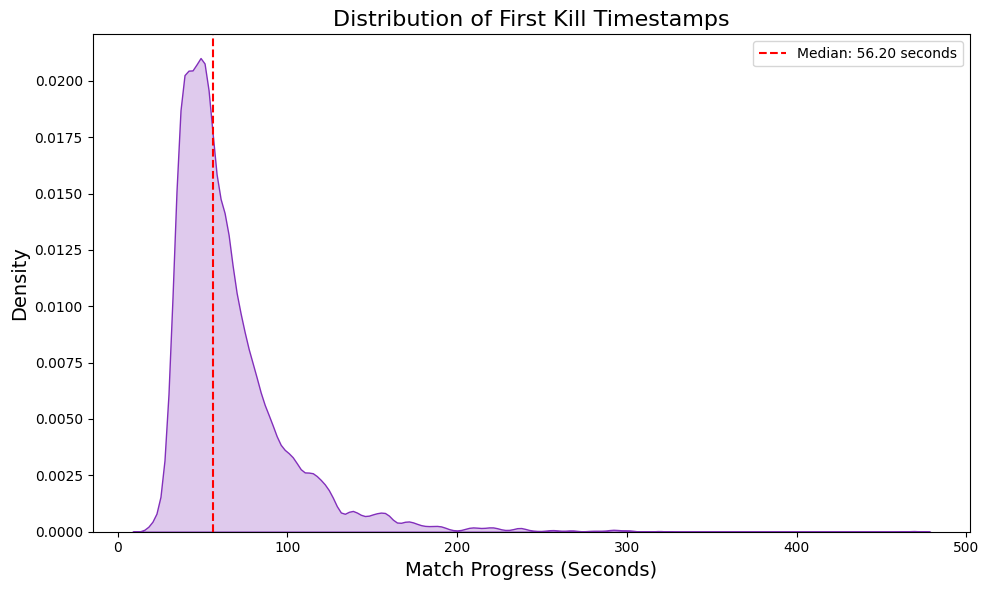

In [67]:

median_tte = df['TimeToEventSeconds'].median()
plt.figure(figsize=(10, 6))
sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')
plt.title('Distribution of First Kill Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Median time to first death

In [68]:
df = pd.read_sql_query('''WITH EventLogData AS (
    SELECT LOWER(MatchID) MatchID, MIN(EventTime) AS MinEventTime
    FROM EventLog
    WHERE XUID = '2533274855333605'
      AND EventType = 20
    GROUP BY MatchID
)

SELECT
    ms.MatchId,
    el.MinEventTime
FROM MatchStats AS ms
JOIN EventLogData AS el ON ms.MatchId = el.MatchID
JOIN json_each(ms.Players) AS player ON json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
WHERE 
    datetime(json_extract(ms.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(ms.MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(ms.MatchInfo, '$.UgcGameVariant.AssetId') NOT IN (
        '1d641733-7cb2-4556-9ec3-f27923af32a1', 
        '15480417-fa8e-49a9-9d4b-e2ae90815562', 
        'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 
        'bc7f495b-c516-414e-acff-9718babe97a5', 
        '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 
        'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', 
        '3ec67f6c-4113-46d3-b94e-b70986625a15', 
        '219f8162-ef34-419e-939b-c3b9dafe3109', 
        'a598de90-4b3f-420a-83d4-c84ba89bf94c'
    )
    AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = false;
''', conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

,MatchId,MinEventTime,TimeToEventSeconds
0,001085b6-163a-41a4-af83-c63bf7a4a59c,57980,57.980
1,0026e8c0-7d32-4e33-8a87-b2c031047e44,60103,60.103
2,00275cb5-a76d-4788-b0ca-43845d693eba,46835,46.835
3,002f007a-d0f9-498f-bbba-b2d740ddc40f,63998,63.998
4,00359920-24f5-431a-aa4f-a6a1fad1e71f,48897,48.897
5,00386052-dc9e-43ad-a11f-66c602ef4821,43490,43.490
6,003fab59-b1fa-4d42-8288-949950e600dd,45866,45.866
7,00704a1f-3214-4867-995d-7e317e5b96ab,83108,83.108
8,0074fe21-9f16-4317-8379-3f4ccc5dfb05,52229,52.229
9,008ac343-f36e-46a1-9a0e-c22f29c552f4,48735,48.735


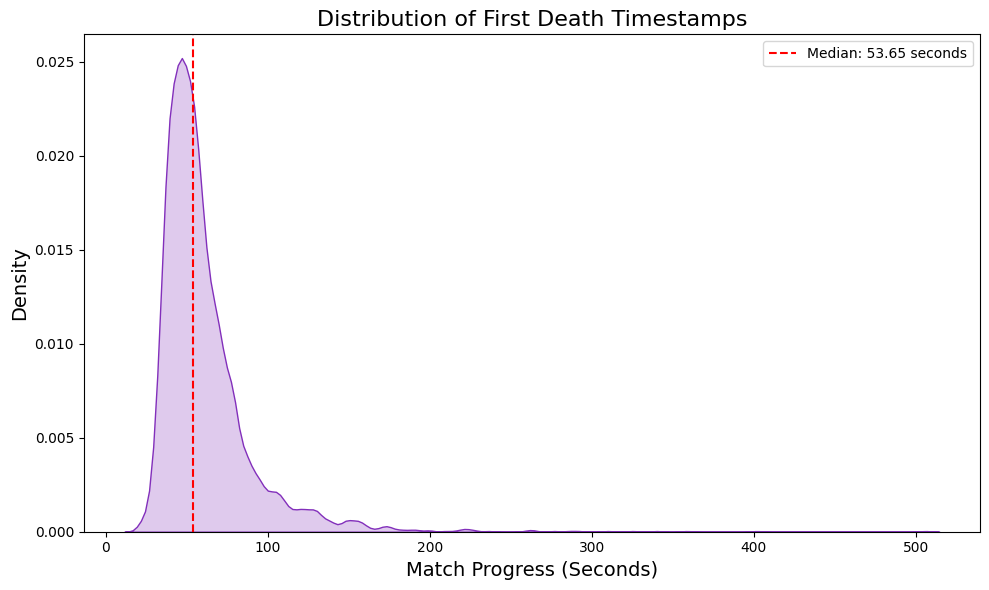

In [69]:

median_tte = df['TimeToEventSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')

plt.title('Distribution of First Death Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Median time to first medal

In [70]:
df = pd.read_sql_query('''WITH EventLogData AS (
    SELECT LOWER(MatchID) MatchID, MIN(EventTime) AS MinEventTime
    FROM EventLog
    WHERE XUID = '2533274855333605'
      AND MedalFlag = 1
    GROUP BY MatchID
)

SELECT
    ms.MatchId,
    el.MinEventTime
FROM MatchStats AS ms
JOIN EventLogData AS el ON ms.MatchId = el.MatchID
JOIN json_each(ms.Players) AS player ON json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
WHERE 
    datetime(json_extract(ms.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(ms.MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(ms.MatchInfo, '$.UgcGameVariant.AssetId') NOT IN (
        '1d641733-7cb2-4556-9ec3-f27923af32a1', 
        '15480417-fa8e-49a9-9d4b-e2ae90815562', 
        'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 
        'bc7f495b-c516-414e-acff-9718babe97a5', 
        '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 
        'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', 
        '3ec67f6c-4113-46d3-b94e-b70986625a15', 
        '219f8162-ef34-419e-939b-c3b9dafe3109', 
        'a598de90-4b3f-420a-83d4-c84ba89bf94c'
    )
    AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = false;
''', conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

,MatchId,MinEventTime,TimeToEventSeconds
0,001085b6-163a-41a4-af83-c63bf7a4a59c,69746,69.746
1,0026e8c0-7d32-4e33-8a87-b2c031047e44,163172,163.172
2,00275cb5-a76d-4788-b0ca-43845d693eba,195669,195.669
3,002f007a-d0f9-498f-bbba-b2d740ddc40f,76811,76.811
4,00359920-24f5-431a-aa4f-a6a1fad1e71f,43376,43.376
5,00386052-dc9e-43ad-a11f-66c602ef4821,61927,61.927
6,003fab59-b1fa-4d42-8288-949950e600dd,32650,32.650
7,00704a1f-3214-4867-995d-7e317e5b96ab,39489,39.489
8,0074fe21-9f16-4317-8379-3f4ccc5dfb05,63373,63.373
9,008ac343-f36e-46a1-9a0e-c22f29c552f4,92846,92.846


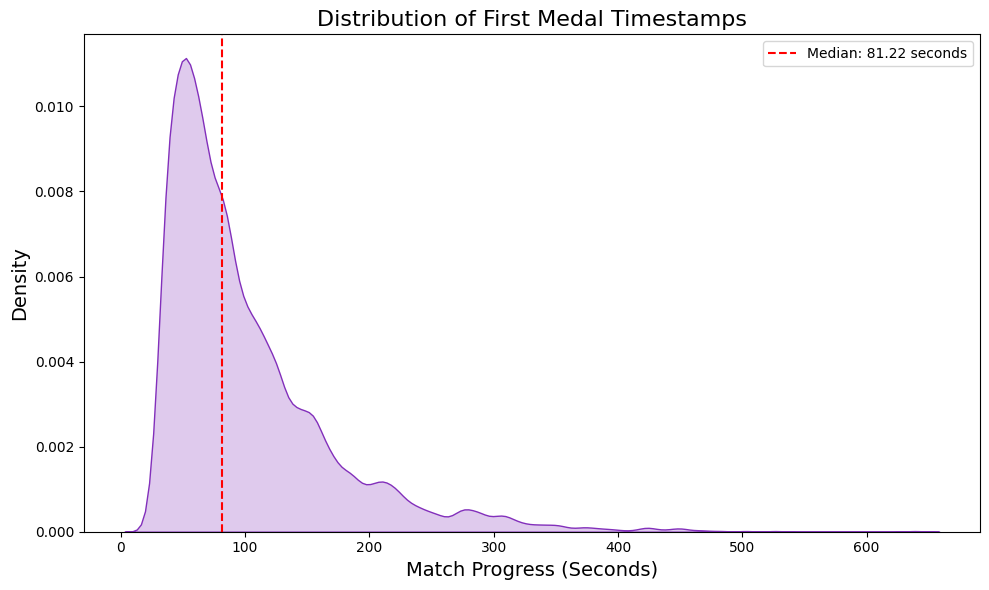

In [71]:
median_tte = df['TimeToEventSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')

plt.title('Distribution of First Medal Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()